In [31]:
using Distances, DataFrames, Color, Gadfly, Distributions, Interact, Reactive

include("TaxonomyExample.jl")
include("BlahutArimoto.jl")
include("InformationTheoryFunctions.jl")
include("ConversionFunctions.jl")
include("VisualizationFunctions.jl")
include("ThreeVariableBlahutArimoto.jl")

#make the default plot size a bit larger
set_default_plot_size(15cm, 12cm)

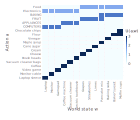

In [12]:
#set up taxonomy example
include("TaxonomyExample.jl")
w_vec, w_strings, a_vec, a_strings, p_w, U = setuptaxonomy()


#pre-compute utilities, find maxima
U_pre, Umax = setuputilityarrays(a_vec,w_vec,U)

#visualize utility
plt_utility = visualizeMatrix(U_pre, w_vec, a_vec, w_strings, a_strings, xlabel="World state w",
                              ylabel="Action a", legendlabel="U(a,w)")

In [60]:
#β1 = 10 #inverse temperature for p(o)→p(o|w)
#β2 = 10 #inverse temperature for p(a)→p(a|o)
#β3 = 4 #inverse temperature for p(a|o)→p(a|o,w)

β1 = 8 #inverse temperature for p(o)→p(o|w)
β2 = 5 #inverse temperature for p(a)→p(a|o)
β3 = 2 #inverse temperature for p(a|o)→p(a|o,w)

#sequential case: β3 is low (lower than the other two)
#parallel case: β2 is high

ε = 0.0000001 #convergence critetion for BAiterations
maxiter = 10000 #maximum number of BA iterations

#cardinality of percept
num_obs = length(a_vec) #cardinality of percept is equal to action-space
o_vec = [1:num_obs]
o_strings = map((x)->"o"*string(x), o_vec)

#initialize p(o|w) and p(a|o,w) uniformly (or randomly)?
uniform_init = false

#This function performs Blahut-Arimoto iterations for the three-variable general case
po, pa, pogw, pago, pagow, pagw, performance_df = threevarBAiterations(num_obs, β1, β2, β3, U_pre, p_w, ε, maxiter,
                                                  compute_performance=true, performance_per_iteration=false,
                                                  performance_as_dataframe=true, init_uniformly=uniform_init)

performance_df

1: ∑p(o) = 1.0
2: ∑p(a) =  1.0


,I_ow,I_ao,I_awgo,I_aw,H_o,H_a,H_ogw,H_ago,H_agow,H_agw,E_U,Objective_value
1,3.5465935572966862,3.5410755716438067,4.357725500115613e-8,3.54107561461933,3.9971053721306204,3.546569292957773,0.4505118148339342,0.005493721313966304,0.005493677736711303,0.005493678338443164,2.99899323605498,1.8474539052755055


In [61]:
#visualize evolution of performance measures over iterations - this has very low priority.
#(maybe quickly check whether the EU increases monotonically over iterations...)

#Check whether different initializations lead to the same solution

#Check whether producing the different special-cases works! (perhaps the random initialization
#leads to problems for the sequential case, since the weight for I(A;W|O) is very large,
#leading to p(a|o)=p(a|o,w), but the initial solutions violate this condition?)
#If producing the special cases by simply setting the temperature properly doesn't work, implement
#the sequential and parallel case as well! (in that case try to write visualization functions that
#can handle any of the cases)

#TODO: when initializing randomly, can it be that inconsistencies between p(o|w) and p(a|o,w) cause problems?

#Another reason for the NaNs could be that entries in distributions are driven to 0, which then 
#causes problems with the D_KL: either add some ϵ, or rewrite the D_KL to handle these cases.

In [62]:
#call the routine that creates plots for all the probability distributions
plt_po, plt_pa, plt_pogw, plt_pago, plt_pagw, dpdown, plt_pagow_vis = visualize_three_var_BAsolution(po, pa,
                                                                      pogw, pago, pagow, pagw,
                                                                      o_vec, a_vec, w_vec,
                                                                      o_strings, a_strings, w_strings, 
                                                                      olabel_string="o", alabel_string="a", wlabel_string="w")

#visualize p(o) and p(a)
display(hstack(plt_po,plt_pa))

#visualize p(o|w)
display(plt_pogw)
#visualize p(a|o)
display(plt_pago)

#visualize p(a|w)
display(plt_pagw)

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Laptop sleeve 
 Monitor cable 
 Video game 
 Coffee 
 Vacuum cleaner bags 
 Brush heads 
 Cheese 
 Cream 
 Cane sugar 
 Maple syrup 
 Vinegar 
 Flour 
 Chocolate chips 
 COMPUTERS 
 APPLIANCES 
 FRUIT 
 BAKING 
 Electronics 
 Food 
 
 
 Action a 
 
 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(o) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 o1 
 o2 
 o3 
 o4 
 o5 
 o6 
 o7 
 o8 
 o9 
 o10 
 o11 
 o12 
 o13 
 o14 
 o15 
 o16 
 o17 
 o18 
 o19 
 
 
 Observation o

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Worldstate w 
 
 
 Laptop 
 Monitor 
 Gamepad 
 Coffee machine 
 Vacuum cleaner 
 Electric toothbrush 
 Grapes 
 Strawberries 
 Limes 
 Pancake mix 
 Baking soda 
 Baker's yeast 
 Muffin cups 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(o|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 o1 
 o2 
 o3 
 o4 
 o5 
 o6 
 o7 
 o8 
 o9 
 o10 
 o11 
 o12 
 o13 
 o14 
 o15 
 o16 
 o17 
 o18 
 o19 
 
 
 Observation o

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Observation o 
 
 
 o1 
 o2 
 o3 
 o4 
 o5 
 o6 
 o7 
 o8 
 o9 
 o10 
 o11 
 o12 
 o13 
 o14 
 o15 
 o16 
 o17 
 o18 
 o19 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a|o) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Laptop sleeve 
 Monitor cable 
 Video game 
 Coffee 
 Vacuum cleaner bags 
 Brush heads 
 Cheese 
 Cream 
 Cane sugar 
 Maple syrup 
 Vinegar 
 Flour 
 Chocolate chips 
 COMPUTERS 
 APPLIANCES 
 FRUIT 
 BAKING 
 Electronics 
 Food 
 
 
 Action a

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 Worldstate w 
 
 
 Laptop 
 Monitor 
 Gamepad 
 Coffee machine 
 Vacuum cleaner 
 Electric toothbrush 
 Grapes 
 Strawberries 
 Limes 
 Pancake mix 
 Baking soda 
 Baker's yeast 
 Muffin cups 
 
 
 
 1.0 
 0.0 
 0.5 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 p(a|w) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 Laptop sleeve 
 Monitor cable 
 Video game 
 Coffee 
 Vacuum cleaner bags 
 Brush heads 
 Cheese 
 Cream 
 Cane sugar 
 Maple syrup 
 Vinegar 
 Flour 
 Chocolate chips 
 COMPUTERS 
 APPLIANCES 
 FRUIT 
 BAKING 
 Electronics 
 Food 
 
 
 Action a

Options{:Dropdown,Int64}([Input{Int64}] 1,"World state w",1,"1",OptionDict({"1","2","3","4","5","6","7","8","9","10","11","12","13"},{"4"=>4,"1"=>1,"12"=>12,"2"=>2,"6"=>6,"11"=>11,"13"=>13,"5"=>5,"7"=>7,"8"=>8,"10"=>10,"9"=>9,"3"=>3}))

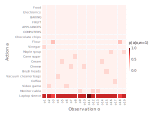

In [63]:
#visualize p(a|o,w)
display(dpdown)  #show the dropdown box to interactively select wk in p(a|o,w=wk)
display(plt_pagow_vis)

#TODO: rather than the number, use the string here for the dropdown (if provided)

In [64]:
p_MI, p_composed, p_perf=plot_three_var_performancemeasures(performance_df, maximum(U_pre))

display(hstack(p_MI, p_composed))
display(p_perf)

#TODO: for 
    #β1 = 8 #inverse temperature for p(o)→p(o|w)
    #β2 = 5 #inverse temperature for p(a)→p(a|o)
    #β3 = 2 #inverse temperature for p(a|o)→p(a|o,w)
#the entropy H(O|W) can't be that large - check for errors, there must be some I(O;W) as well, it can't be zero!


<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 H(O) 
 H(A) 
 H(A|O) 
 H(A) 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 H(O|W) 
 H(A|O) 
 H(A|O,W) 
 H(A|W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 -5 
 0 
 5 
 10 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 
 
 [bits] 
 
 
 Composition of entropic terms 
 
 
 
 
 I(O;W) 
 I(A;O) 
 I(A;W|O) 
 I(A;W) 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -5 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 -4.0 
 -3.8 
 -3.6 
 -3.4 
 -3.2 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 6.2 
 6.4 
 6.6 
 6.8 
 7.0 
 7.2 
 7.4 
 7.6 
 7.8 
 8.0 
 -5 
 0 
 5 
 10 
 -4.0 
 -3.5 
 -3.0 
 -2.5 
 -2.0 
 -1.5 
 -1.0 
 -0.5 
 0.0 
 0.5 
 1.0 
 1.5 
 2.0 
 2.5 
 3.0 
 3.5 
 4.0 
 4.5 
 5.0 
 5.5 
 6.0 
 6.5 
 7.0 
 7.5 
 8.0 
 
 
 [bits] 
 
 
 Mutual information terms

<?xml version="1.0" encoding="UTF-8"?>
 
 
 
 E[U] 
 J = E[U] - 1/β ∑ I 
 
 
 
 E[U] 
 J = E[U] - 1/β ∑ I 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 
 -4 
 -3 
 -2 
 -1 
 0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 -3.0 
 -2.9 
 -2.8 
 -2.7 
 -2.6 
 -2.5 
 -2.4 
 -2.3 
 -2.2 
 -2.1 
 -2.0 
 -1.9 
 -1.8 
 -1.7 
 -1.6 
 -1.5 
 -1.4 
 -1.3 
 -1.2 
 -1.1 
 -1.0 
 -0.9 
 -0.8 
 -0.7 
 -0.6 
 -0.5 
 -0.4 
 -0.3 
 -0.2 
 -0.1 
 0.0 
 0.1 
 0.2 
 0.3 
 0.4 
 0.5 
 0.6 
 0.7 
 0.8 
 0.9 
 1.0 
 1.1 
 1.2 
 1.3 
 1.4 
 1.5 
 1.6 
 1.7 
 1.8 
 1.9 
 2.0 
 2.1 
 2.2 
 2.3 
 2.4 
 2.5 
 2.6 
 2.7 
 2.8 
 2.9 
 3.0 
 3.1 
 3.2 
 3.3 
 3.4 
 3.5 
 3.6 
 3.7 
 3.8 
 3.9 
 4.0 
 4.1 
 4.2 
 4.3 
 4.4 
 4.5 
 4.6 
 4.7 
 4.8 
 4.9 
 5.0 
 5.1 
 5.2 
 5.3 
 5.4 
 5.5 
 5.6 
 5.7 
 5.8 
 5.9 
 6.0 
 -3 
 0 
 3 
 6 
 -3.0 
 -2.8 
 -2.6 
 -2.4 
 -2.2 
 -2.0 
 -1.8 
 -1.6 
 -1.4 
 -1.2 
 -1.0 
 -0.8 
 -0.6 
 -0.4 
 -0.2 
 0.0 
 0.2 
 0.4 
 0.6 
 0.8 
 1.0 
 1.2 
 1.4 
 1.6 
 1.8 
 2.0 
 2.2 
 2.4 
 2.6 
 2.8 
 3.0 
 3.2 
 3.4 
 3.6 
 3.8 
 4.0 
 4.2 
 4.4 
 4.6 
 4.8 
 5.0 
 5.2 
 5.4 
 5.6 
 5.8 
 6.0 
 
 
 [utils]

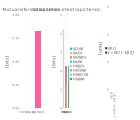

In [22]:
#for the paper
hstack(p_MI, p_composed, p_perf)